# Example: Optuna Interface

In this notebook, we will demonstrate the `UnconstrainedGPEISampler` that can be used with Optuna, and constrast it with the default `TPESampler` in Optuna. This requires the Optuna package to be installed. We will optimize the `branin` function, which is a common benchmark function for optimization algorithms.

Some observations:
- Gaussian Process (GP) based algorithms are generally more sample efficient than Tree-structured Parzen Estimator (TPE) based algorithms in terms of the number of evaluations required to find the minimum as well as the convergence speed.
- That being said, there is a small computational overhead associated with GP based algorithms. However, in typical use cases for both algorithms, this overhead is much less than the time spent evaluating the objective function.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import optuna
import warnings

from gp_bo.optim.optuna_ei import UnconstrainedGPEISampler
from linear_operator.utils.warnings import NumericalWarning


plt.rcParams.update({'figure.dpi': 100})
plt.style.use('ggplot')

In [2]:
# define the branin objective function
def branin_optuna_obj(trial: optuna.Trial):
    # define the inputs
    x1 = trial.suggest_float('x1', -5, 10)
    x2 = trial.suggest_float('x2', 0, 15)

    # define the branin function
    term1 = (x2 - 5.1 / (4 * np.pi **2) * x1**2 + 5 / 3.14 * x1 - 6)**2
    term2 = 10 * (1 - 1 / (8 * 3.14)) * np.cos(x1)
    return term1 + term2 + 10

In [3]:
# Initial design and reproducibility parameters
SEED = 1234 # random seed
N_STARTUP_TRIALS = 5 # number of initial random design points
TOTAL_TRIALS = 75 # total number of trials

# Setup Optuna logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [4]:
# Optimize branin using the TPE sampler
study_tpe = optuna.create_study(
    sampler=optuna.samplers.TPESampler(
        n_startup_trials=N_STARTUP_TRIALS,
        seed=SEED,
    ), 
    directions=['minimize'], study_name='branin_tpe'
)

# run optimization for a total of 100 evaluations
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=optuna.exceptions.ExperimentalWarning)    
    study_tpe.optimize(branin_optuna_obj, n_trials=TOTAL_TRIALS, show_progress_bar=True)

  0%|          | 0/75 [00:00<?, ?it/s]

In [5]:
# Optimize branin using the GP-BO
study_bo = optuna.create_study(
    sampler=UnconstrainedGPEISampler(
        n_startup_trials=N_STARTUP_TRIALS,
        seed=SEED,
        independent_sampler=optuna.samplers.RandomSampler(seed=SEED),
    ), 
    directions=['minimize'], study_name='branin_bo'
)

# run optimization for a total of 100 evaluations
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=optuna.exceptions.ExperimentalWarning)
    warnings.filterwarnings("ignore", category=NumericalWarning)
    study_bo.optimize(branin_optuna_obj, n_trials=TOTAL_TRIALS, show_progress_bar=True)

  0%|          | 0/75 [00:00<?, ?it/s]

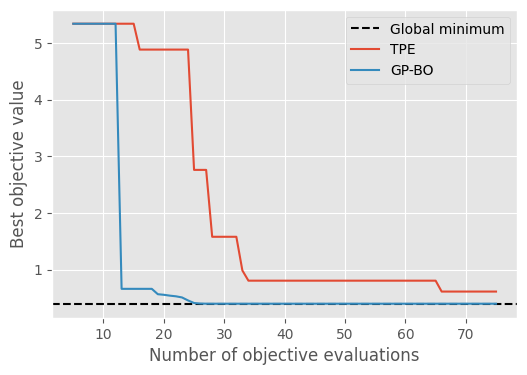

In [6]:
# plot optimization progress
tpe_profile = np.minimum.accumulate([trial.values[0] for trial in study_tpe.trials])[N_STARTUP_TRIALS - 1:]
bo_profile = np.minimum.accumulate([trial.values[0] for trial in study_bo.trials])[N_STARTUP_TRIALS - 1:]

fig,ax = plt.subplots(1,1,figsize=(6,4))
_ = ax.axhline(0.397887, color='black', linestyle='--', label='Global minimum')
_ = ax.plot(np.arange(N_STARTUP_TRIALS, TOTAL_TRIALS + 1), tpe_profile, '-',label='TPE')
_ = ax.plot(np.arange(N_STARTUP_TRIALS, TOTAL_TRIALS + 1), bo_profile,'-',label='GP-BO')

_ = ax.set_xlabel('Number of objective evaluations')
_ = ax.set_ylabel('Best objective value')
_ = ax.legend()